In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Import Data

In [2]:
df_red_wine = pd.read_csv('src/winequality-red.csv',delimiter=';')
df_white_wine = pd.read_csv('src/winequality-white.csv',delimiter=';')

# Pre-processing

In [3]:
vals_red = dict(df_red_wine['quality'].value_counts())
vals_white = dict(df_white_wine['quality'].value_counts())
x_axis = list(range(11))
values = [[vals_red.get(elt) if vals_red.get(elt) != None else 0 for elt in x_axis],[vals_white.get(elt) if vals_white.get(elt) != None else 0 for elt in x_axis]]

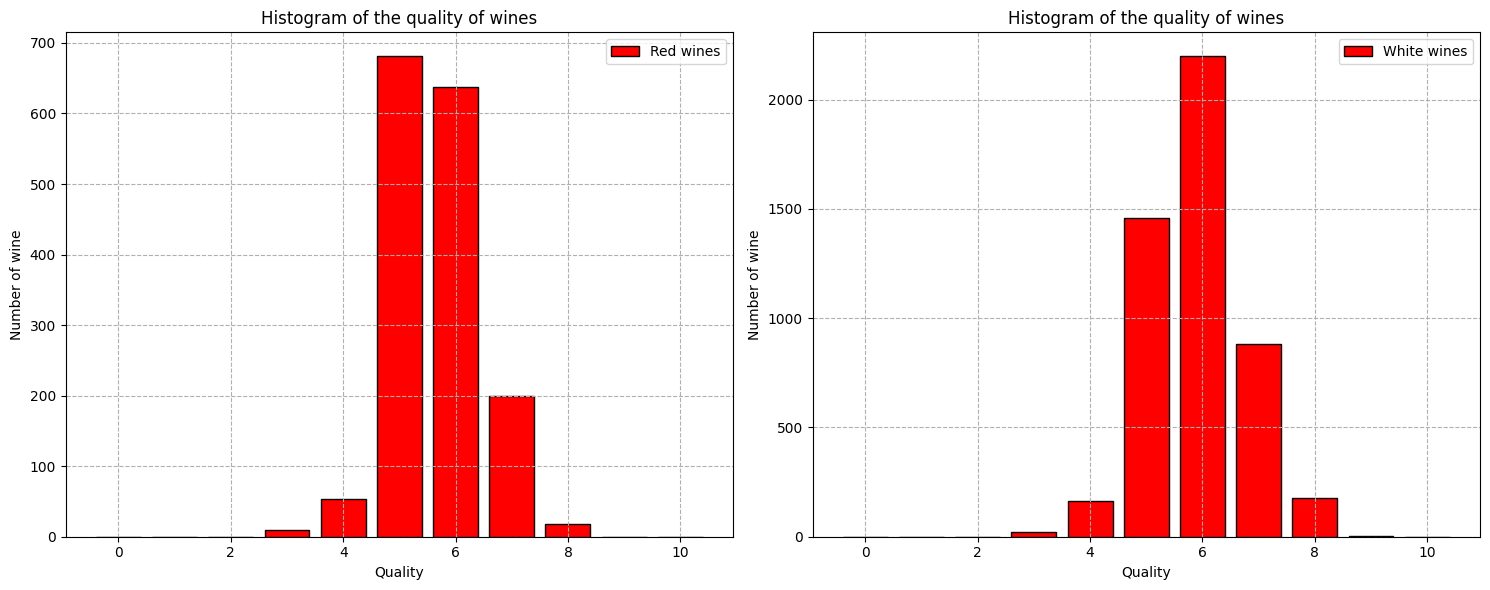

In [4]:
labels = ['Red wines','White wines']
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6),sharey=False)
for i,val in enumerate(values):
    ax[i].bar(x_axis,height=val,color='r',edgecolor='k',label=labels[i])
    ax[i].set_xlabel('Quality')
    ax[i].set_ylabel('Number of wine')
    ax[i].grid(linestyle='--')
    ax[i].legend()
    ax[i].set_title('Histogram of the quality of wines')
    plt.tight_layout()
    ax[i].tick_params(axis='x', rotation=0)
plt.show()

The datasets classes are really imbalanced. The average qualities are dominating. To begin with, we will drop classes with less than **30** values.

In [5]:
r_square_red = df_red_wine.corr()['quality']**2

In [6]:
r_square_white = df_white_wine.corr()['quality']**2

In [7]:
print(r_square_red.sort_values(ascending=False))

quality                 1.000000
alcohol                 0.226734
volatile acidity        0.152535
sulphates               0.063200
citric acid             0.051245
total sulfur dioxide    0.034262
density                 0.030597
chlorides               0.016617
fixed acidity           0.015389
pH                      0.003333
free sulfur dioxide     0.002566
residual sugar          0.000189
Name: quality, dtype: float64


In [8]:
print(r_square_white.sort_values(ascending=False))

quality                 1.000000
alcohol                 0.189725
density                 0.094325
chlorides               0.044072
volatile acidity        0.037917
total sulfur dioxide    0.030533
fixed acidity           0.012919
pH                      0.009886
residual sugar          0.009521
sulphates               0.002881
citric acid             0.000085
free sulfur dioxide     0.000067
Name: quality, dtype: float64


The correlation between the features and the quality is not the same depending on the type of wine. Since the correlation with many feature is weak, we will only keep the features with a $r^2 > 0.05$.

#### Drop features

In [9]:
# Drop uncorrelated features
feature_kept_red = list(r_square_red[r_square_red > 0.05].index)
feature_kept_white = list(r_square_white[r_square_white > 0.05].index)

df_red_wine_filtered = df_red_wine[feature_kept_red]
df_white_wine_filtered = df_white_wine[feature_kept_white]


# Drop classes with too few values
temp_red = df_red_wine_filtered['quality'].value_counts() >= 30
class_red = temp_red[temp_red == True].index

temp_white = df_white_wine_filtered['quality'].value_counts() >= 30
class_white = temp_white[temp_white == True].index

df_red_wine_filtered = df_red_wine_filtered[df_red_wine_filtered['quality'].isin(class_red)]
df_white_wine_filtered = df_white_wine_filtered[df_white_wine_filtered['quality'].isin(class_white)]




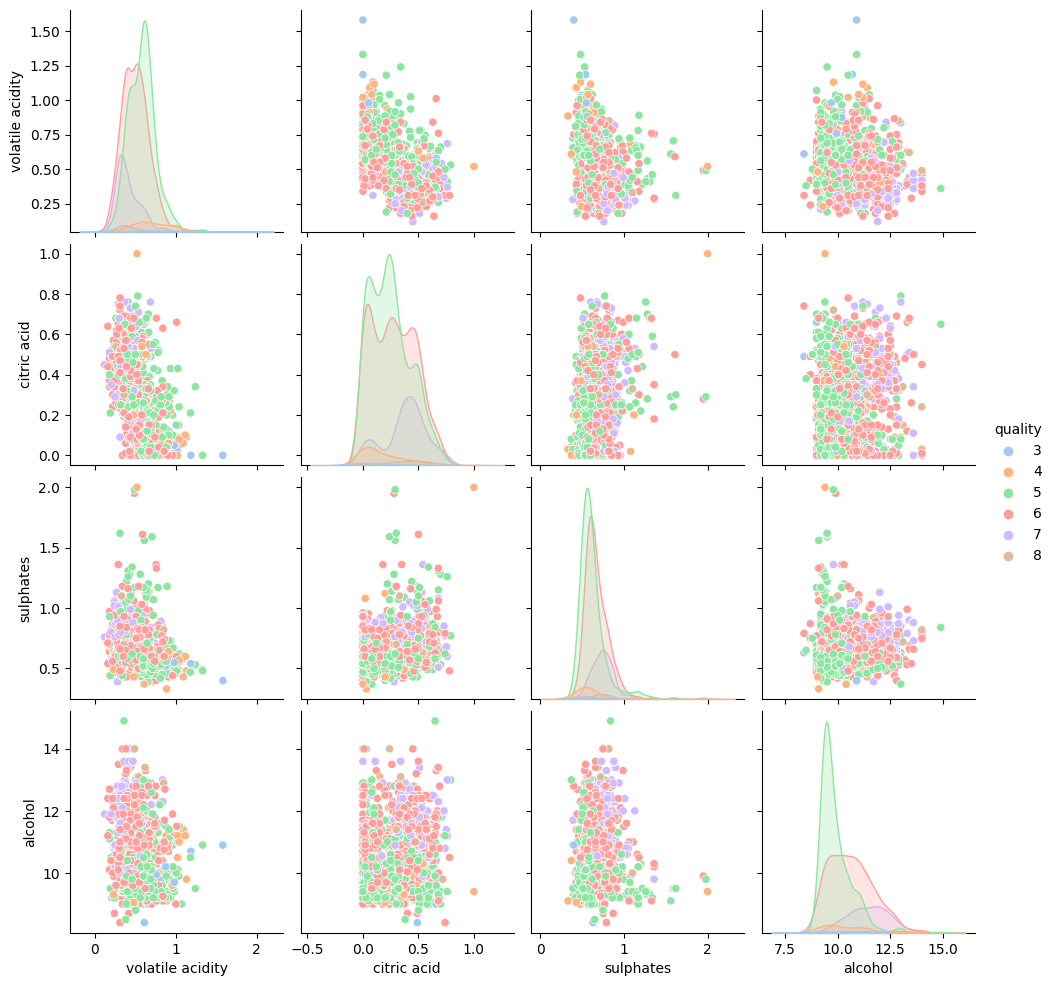

In [69]:
sns.pairplot(df_red_wine_filtered,hue='quality',palette='pastel')

From this visualisation we observe that it will be possible to do some clustering especially for qualities 5,6,7. The volatile acidity wrt alcohol representation is the most promising. It seems possible to cluster qualities 4,5,6,7,8 but using circular kernel like Kmeans might not fit the way we want.
According to the density histograms, only the alcohol feature will allow us to make some assumptions depending on the value.

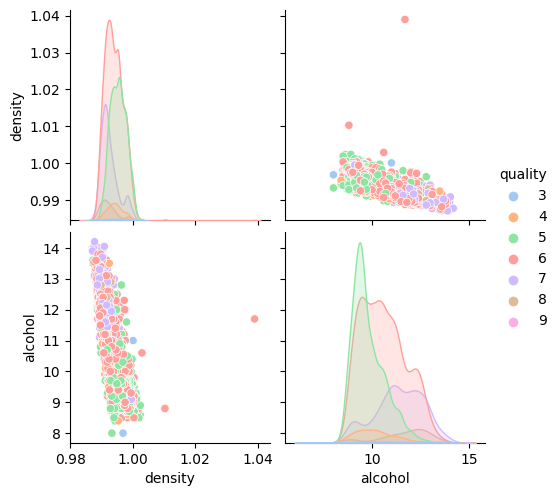

In [70]:
sns.pairplot(df_white_wine_filtered,hue='quality',palette='pastel')

For the white wine we have fewer features. The data seems to be on a straight line. Maybe it will be possible to do some regression.

# Model

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler,Normalizer,RobustScaler,StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,BayesianRidge
from sklearn.svm import SVC,SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.parse import urlparse
import mlflow.sklearn
import mlflow

In [17]:
wine_df = df_white_wine_filtered
train_df, test_df = train_test_split(wine_df,test_size=0.2)

y_train = train_df.pop("quality")

# convert the dataframe values to array
X_train = train_df.values

# Extracting the label column
y_test = test_df.pop("quality")

# convert the dataframe values to array
X_test = test_df.values

In [12]:
scalers = [None,MinMaxScaler(),Normalizer(),RobustScaler(),StandardScaler()]
regressors = [LinearRegression(),Ridge(),SGDRegressor(),BayesianRidge(),SVR()]
classifiers = [SVC()]

In [13]:
pipes = []
scores = []

for scaler in scalers:
    for regressor in regressors:
        pipes.append(Pipeline([('scaler', scaler), ('reg', regressor)]))      
        
for _, pipe in enumerate(pipes):
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    scores.append(score)

In [88]:
argmax = np.argmax(scores)
print(f'{[elt for elt in pipes[argmax]]} score : {scores[argmax]}')


[MinMaxScaler(), Ridge()] score : 0.3313989075763466


In [14]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


In [15]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("Project Data Mining")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1669629979912, experiment_id='2', last_update_time=1669629979912, lifecycle_stage='active', name='Project Data Mining', tags={}>

In [16]:
pipes = []
scores = []

for scaler in scalers:
    for regressor in regressors:
        pipes.append(Pipeline([('scaler', scaler), ('reg', regressor)]))

for scaler in scalers:
    for classifier in classifiers:
        pipes.append(Pipeline([('scaler', scaler), ('classif', classifier)]))


for i, pipe in enumerate(pipes):
    print(pipe)
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f'white wine : {i}')
        pipe.fit(X_train, y_train)
        #score = pipe.score(X_test, y_test)
        # scores.append(score)
        predicted_qualities = pipe.predict(X_test)
        rmse, mae, r2 = eval_metrics(y_test, predicted_qualities)
        mlflow.log_param("scaler", f'{pipe["scaler"]}')
        try:
            mlflow.log_param("reg", f'{pipe["reg"]}')
        except KeyError:
            pass
        try:
            mlflow.log_param("classif", f'{pipe["classif"]}')
        except KeyError:
            pass 
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

Pipeline(steps=[('scaler', None), ('reg', LinearRegression())])
Pipeline(steps=[('scaler', None), ('reg', Ridge())])
Pipeline(steps=[('scaler', None), ('reg', SGDRegressor())])
Pipeline(steps=[('scaler', None), ('reg', BayesianRidge())])
Pipeline(steps=[('scaler', None), ('reg', SVR())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', LinearRegression())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', Ridge())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', SGDRegressor())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', BayesianRidge())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', SVR())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', LinearRegression())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', Ridge())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', SGDRegressor())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', BayesianRidge())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', SVR())])
Pipeline(steps=[('scaler', RobustScaler()),

In [124]:
from sklearn.metrics import classification_report

In [131]:
#Single experiment
with mlflow.start_run():
    pipe = Pipeline([('scaler', None), ('classif', KMeans())])

    pipe.fit(X_train, y_train)
    predicted_qualities = pipe.predict(X_test)
    rmse, mae, r2 = eval_metrics(y_test, predicted_qualities)
    mlflow.log_param("scaler", f'{pipe["scaler"]}')
    try:
        mlflow.log_param("reg", f'{pipe["reg"]}')
    except KeyError:
        pass
    
    try:
        mlflow.log_param("classif", f'{pipe["classif"]}')
    except KeyError:
        pass
    
    print(classification_report(y_test,predicted_qualities,output_dict=True))

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)    

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '4': {'precision': 0.0684931506849315, 'recall': 0.3333333333333333, 'f1-score': 0.11363636363636363, 'support': 30}, '5': {'precision': 0.2571428571428571, 'recall': 0.15570934256055363, 'f1-score': 0.1939655172413793, 'support': 289}, '6': {'precision': 0.35714285714285715, 'recall': 0.07092198581560284, 'f1-score': 0.1183431952662722, 'support': 423}, '7': {'precision': 0.5882352941176471, 'recall': 0.05291005291005291, 'f1-score': 0.0970873786407767, 'support': 189}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 45}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'accuracy': 0.09693877551020408, 'macro avg': {'precision': 0.12710141590882928, 'recall': 0.061

C:\Users\Yhosy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yhosy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yhosy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

# Supervised 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score,accuracy_score


In [20]:
params_tree = {'criterion':['gini', 'entropy', 'log_loss'],
          'splitter':['best', 'random'],
            'max_depth':list(range(2,100,5)),
             'min_samples_split' : list(range(5,50,5))
         }

In [21]:
clf = GridSearchCV(DecisionTreeClassifier(),params_tree,cv=5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52,
                                       57, 62, 67, 72, 77, 82, 87, 92, 97],
                         'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40,
                                               45],
                         'splitter': ['best', 'random']})

In [22]:
best_params = clf.best_params_
print(best_params)

{'criterion': 'entropy', 'max_depth': 82, 'min_samples_split': 5, 'splitter': 'best'}


In [23]:
best_classifier = DecisionTreeClassifier(**best_params)
best_classifier.fit(X_train,y_train)
print(best_classifier.score(X_test,y_test))

0.5405128205128205


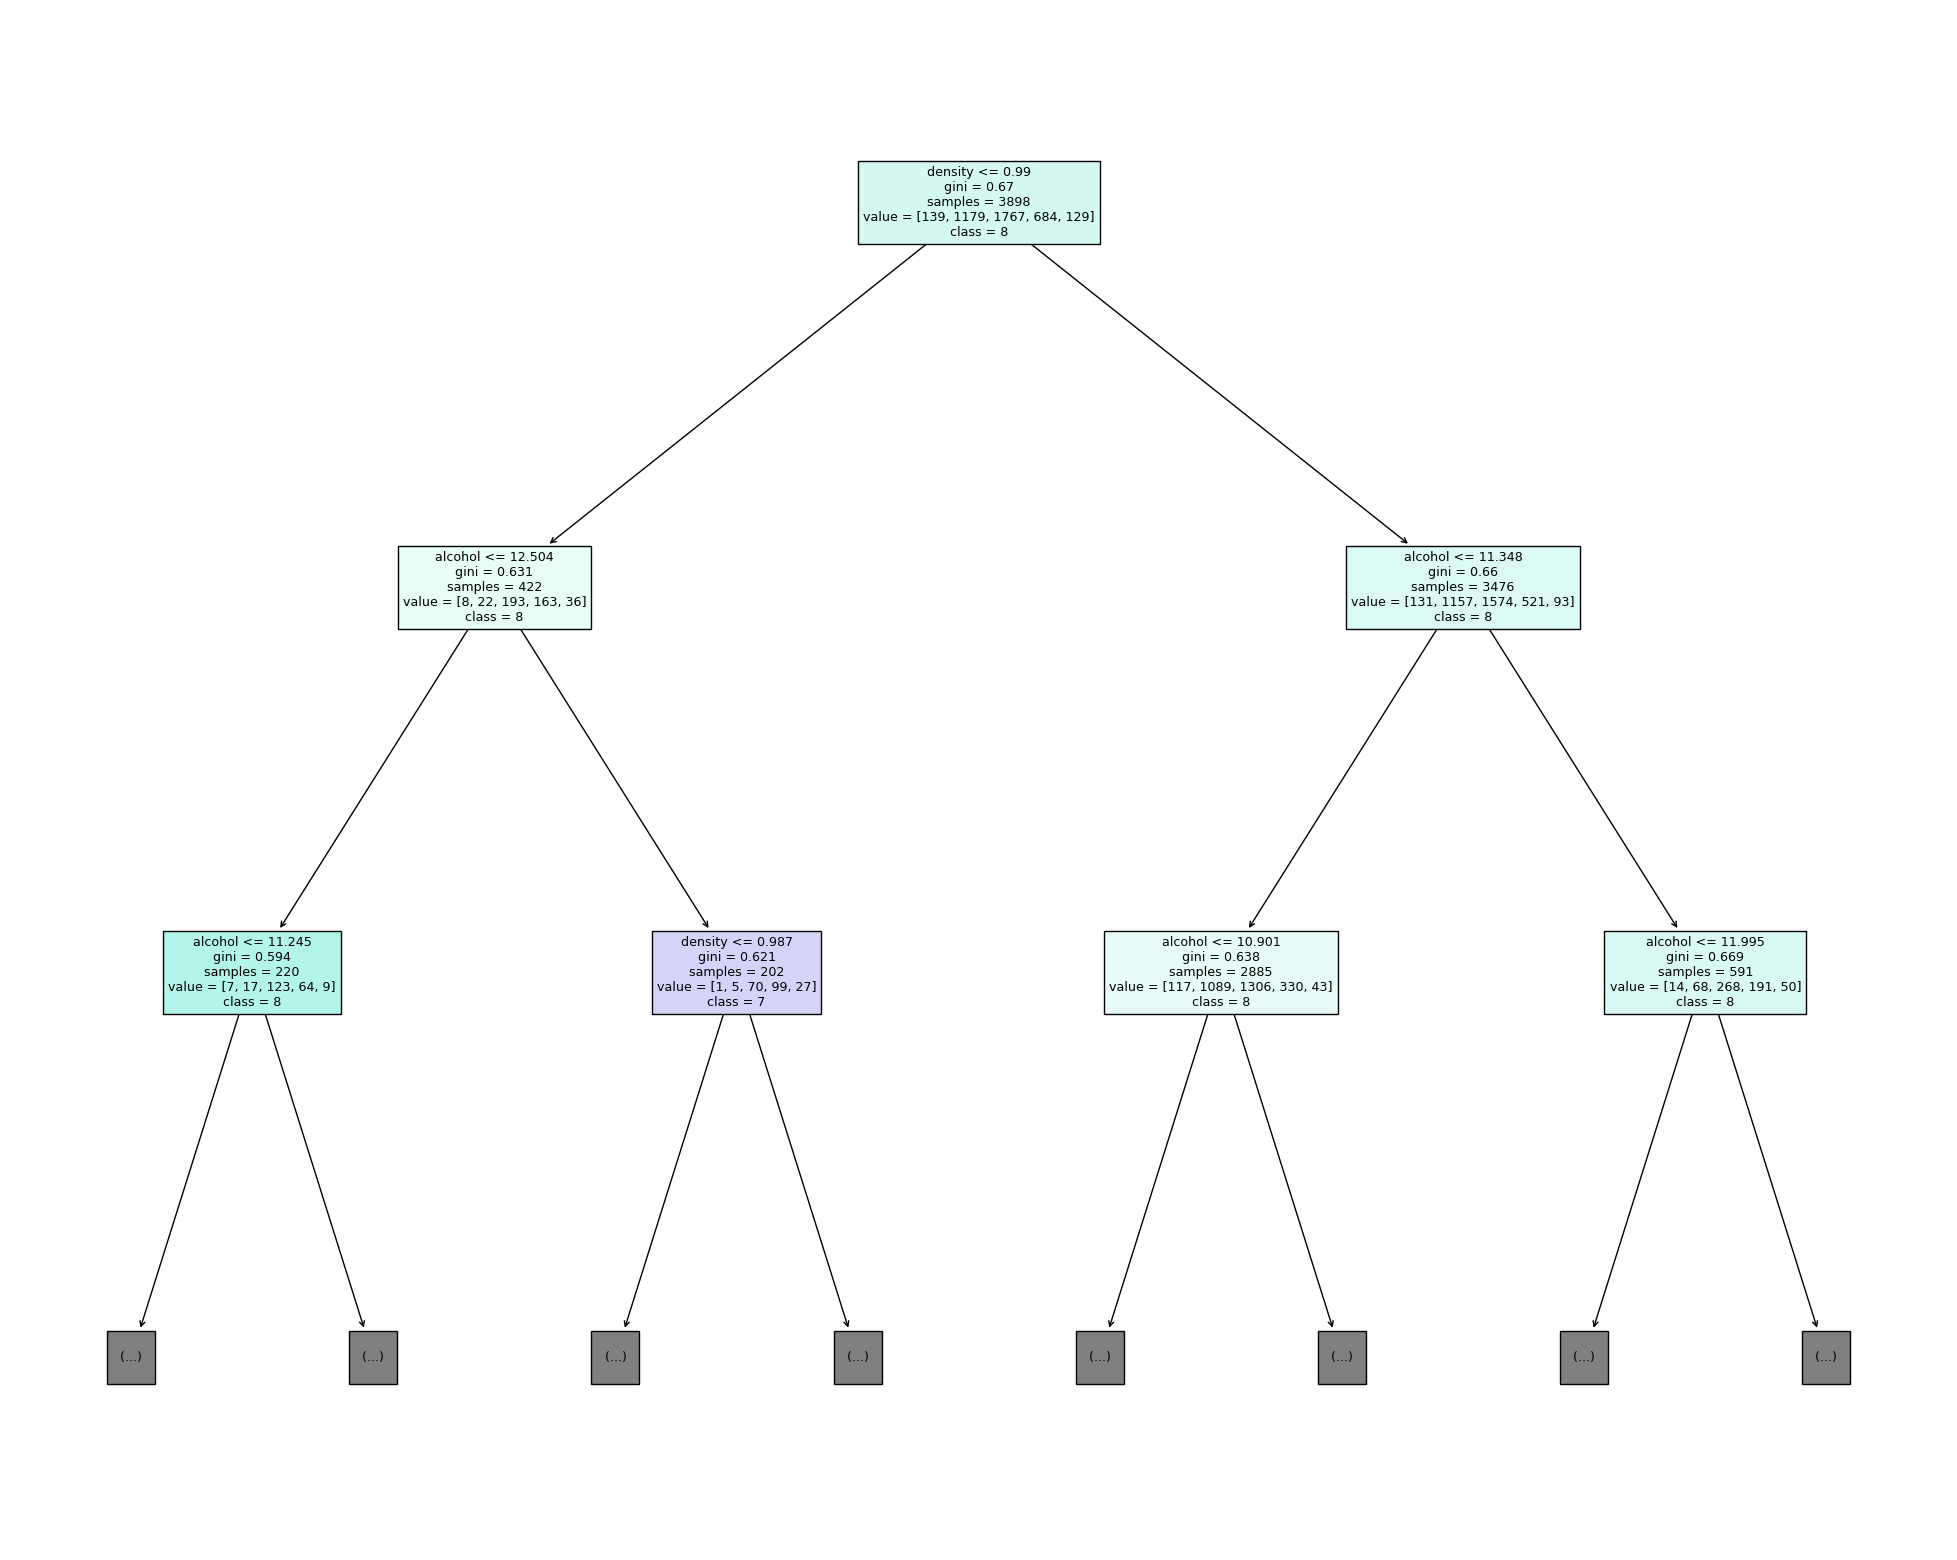

In [377]:
class_names = [str(elt) for elt in y_train.unique()]
fig = plt.figure(figsize=(25,20))
plot_tree(best_classifier,feature_names=X_train.columns,class_names=class_names,max_depth=2,filled=True)
plt.show()

There is too much variability with a single decision tree. From one run to another the best parameters can completly change. The best score we have reached is 56%. We will try too smooth the results with a random forest.

In [24]:
params_forest = {'n_estimators': list(range(10, 20, 10)),
                 'criterion': ['gini', 'entropy', 'log_loss'],
                 'max_depth': list(range(2, 100, 10)),
                 'min_samples_split': list(range(5, 50, 5))
                 }

In [25]:
clf = GridSearchCV(RandomForestClassifier(),params_forest,cv=5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 12, 22, 32, 42, 52, 62, 72, 82, 92],
                         'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40,
                                               45],
                         'n_estimators': [10]})

In [393]:
best_params = clf.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 92, 'min_samples_split': 5, 'n_estimators': 10}


In [394]:
best_classifier = RandomForestClassifier(**best_params)
best_classifier.fit(X_train,y_train)
print(best_classifier.score(X_test,y_test))

0.5620512820512821
